In [67]:
# Import required packages
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow
import tensorflow.keras as keras
import timeit
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import svm
from sklearn import metrics
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.constraints import maxnorm
from keras.wrappers.scikit_learn import KerasClassifier


In [2]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


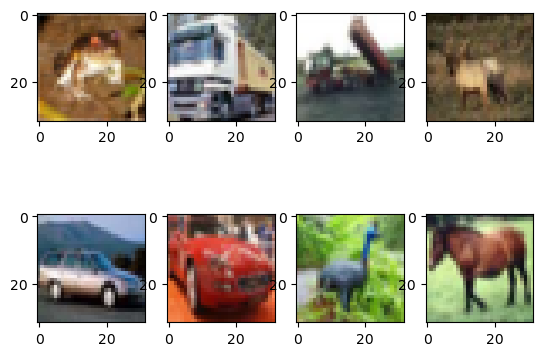

In [3]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))

In [4]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [5]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

In [6]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

In [ ]:
# Now, we've realized the unsatisfactory results from the baseline model. Hence, we will use CNN model as model to
# improve prediction performances

In [79]:
# First, treat 50000 noisy labels as clean labels and split the dataset into train and test set
imgs_train, imgs_test, noisy_labels_train, noisy_labels_test  = train_test_split(imgs, noisy_labels, test_size=0.2, random_state=0)

In [80]:
# Normalize pixel values to be between 0 and 1
images_train = np.array(imgs_train) / 255
images_test = np.array(imgs_test) / 255

In [88]:
# Model 1: CNN
#create the model
model = Sequential()

#add model layers    
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(10)) # 10 categories
    
# compile the model
model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    
# train the model
history = model.fit(images_train, noisy_labels_train, epochs=10, validation_data=(images_test, noisy_labels_test))
    
history

Epoch 1/10
1250/1250 [==============================] - 24s 18ms/step - loss: 2.2849 - accuracy: 0.1325 - val_loss: 2.2589 - val_accuracy: 0.1632
Epoch 2/10
1250/1250 [==============================] - 24s 19ms/step - loss: 2.2480 - accuracy: 0.1792 - val_loss: 2.2445 - val_accuracy: 0.1837
Epoch 3/10
1250/1250 [==============================] - 20s 16ms/step - loss: 2.2250 - accuracy: 0.2043 - val_loss: 2.2407 - val_accuracy: 0.1945
Epoch 4/10
1250/1250 [==============================] - 22s 18ms/step - loss: 2.2075 - accuracy: 0.2198 - val_loss: 2.2227 - val_accuracy: 0.2147
Epoch 5/10
1250/1250 [==============================] - 23s 18ms/step - loss: 2.1920 - accuracy: 0.2303 - val_loss: 2.2200 - val_accuracy: 0.2243
Epoch 6/10
1250/1250 [==============================] - 25s 20ms/step - loss: 2.1725 - accuracy: 0.2417 - val_loss: 2.2273 - val_accuracy: 0.2262
Epoch 7/10
1250/1250 [==============================] - 25s 20ms/step - loss: 2.1515 - accuracy: 0.2524 - val_loss: 2.2288 -

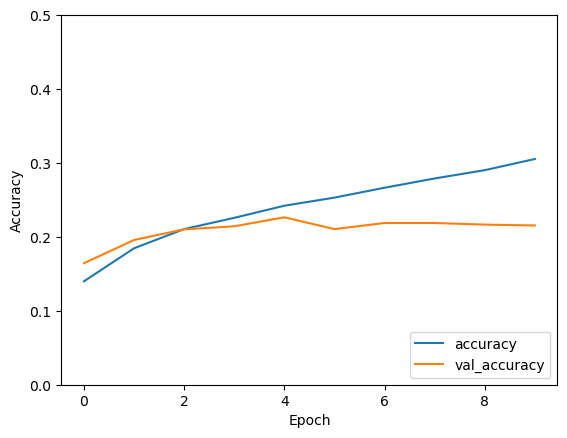

313/313 - 2s - loss: 208.4963 - accuracy: 0.1576 - 2s/epoch - 5ms/step


In [83]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 0.5])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(imgs_test,  noisy_labels_test, verbose=2)

In [89]:
print(test_acc)

0.15760000050067902


In [ ]:
# Notice that the validation accuracy is around 20% which is better than random guess which theoratically has 10% accuracy

In [ ]:
# Model II: Train the model using data set with clean labels

In [90]:
imgs_train_2, imgs_test_2, clean_labels_train, clean_labels_test  = train_test_split(imgs[0:10000], clean_labels, test_size=0.2, random_state=1)

In [91]:
# Normalize pixel values to be between 0 and 1
images_train_2 = np.array(imgs_train_2) / 255
images_test_2 = np.array(imgs_test_2) / 255

In [92]:
model = Sequential()

#add model layers    
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(10)) # 10 categories
    
# compile the model
model.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    
# train the model
history = model.fit(images_train_2, clean_labels_train, epochs=10, validation_data=(images_test_2, clean_labels_test))
    
history

Epoch 1/10
250/250 [==============================] - 5s 17ms/step - loss: 1.9723 - accuracy: 0.2645 - val_loss: 1.7017 - val_accuracy: 0.3745
Epoch 2/10
250/250 [==============================] - 4s 18ms/step - loss: 1.6236 - accuracy: 0.4008 - val_loss: 1.4800 - val_accuracy: 0.4640
Epoch 3/10
250/250 [==============================] - 5s 18ms/step - loss: 1.4402 - accuracy: 0.4716 - val_loss: 1.3740 - val_accuracy: 0.4990
Epoch 4/10
250/250 [==============================] - 5s 19ms/step - loss: 1.3381 - accuracy: 0.5179 - val_loss: 1.3335 - val_accuracy: 0.5155
Epoch 5/10
250/250 [==============================] - 5s 21ms/step - loss: 1.2489 - accuracy: 0.5545 - val_loss: 1.3132 - val_accuracy: 0.5310
Epoch 6/10
250/250 [==============================] - 4s 17ms/step - loss: 1.1944 - accuracy: 0.5732 - val_loss: 1.2868 - val_accuracy: 0.5455
Epoch 7/10
250/250 [==============================] - 5s 18ms/step - loss: 1.1132 - accuracy: 0.6086 - val_loss: 1.2607 - val_accuracy: 0.5670

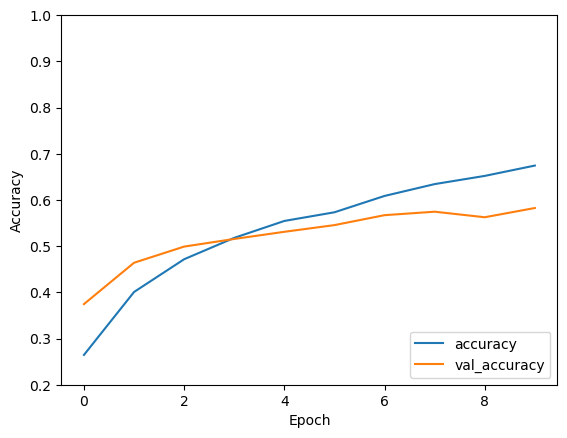

63/63 - 0s - loss: 217.7597 - accuracy: 0.4880 - 324ms/epoch - 5ms/step


In [95]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(imgs_test_2,  clean_labels_test, verbose=2)

In [96]:
print(test_acc)

0.4880000054836273


In [ ]:
# As observed, the model prediction accuracy is tremendously improved, to around 50%.